In [1]:
# Matplotlib
%matplotlib inline
from matplotlib import rc

import GPy
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter
import os

# Take care of some general properties of the plots:much
rc('text', usetex=True)
rc('font', family='serif',size=20)

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20#20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



import warnings
warnings.filterwarnings('ignore')

# High fidelity GP model

Data for metamateria unit cell generated for variaous $P-D$ vs $I_x$ combinations
Other parameters stay constant:

in total 100 training points, sampled with Sobol scheme (look F3DAS code )


In [2]:
from QGP_metamaterial_postproc import Analyze
from QGP_metamaterial_postproc import combined_qgp_plot
from QGP_metamaterial_postproc import postproc_QGP_2d
from QGP_metamaterial_postproc import plot_GP_classification_2d


analysis_folder = 'DOE_Ix-PD-100'
dir_path = os.path.dirname(os.getcwd()+'/Set-PD-Ix-100/') 


E = Analyze(dir_path)
E.quick_load_data(analysis_folder)
E.derive_results()

E_dict = E.data_to_dict()

Failed Sample (ikj): 0 0 3
Failed Sample (ikj): 0 0 4
Failed Sample (ikj): 0 0 8
Failed Sample (ikj): 0 0 15
Failed Sample (ikj): 0 0 18
Failed Sample (ikj): 0 0 21
Failed Sample (ikj): 0 0 25
Failed Sample (ikj): 0 0 29
Failed Sample (ikj): 0 0 32
Failed Sample (ikj): 0 0 34
Failed Sample (ikj): 0 0 37
Failed Sample (ikj): 0 0 41
Failed Sample (ikj): 0 0 46
Failed Sample (ikj): 0 0 48
Failed Sample (ikj): 0 0 51
Failed Sample (ikj): 0 0 55
Failed Sample (ikj): 0 0 59
Failed Sample (ikj): 0 0 60
Failed Sample (ikj): 0 0 64
Failed Sample (ikj): 0 0 71
Failed Sample (ikj): 0 0 72
Failed Sample (ikj): 0 0 75
Failed Sample (ikj): 0 0 76
Failed Sample (ikj): 0 0 81
Failed Sample (ikj): 0 0 86
Failed Sample (ikj): 0 0 89
Failed Sample (ikj): 0 0 90
Failed Sample (ikj): 0 0 93
Failed Sample (ikj): 0 0 97
Non-coilable designs have been filtered out! 


## Classification

Here I build a small GP model for classifying coilable and non-coilable designs

In [3]:
X_failed = []
for j in np.array(E._failed_samples)[:, 2]:
    X_failed.append(E._Input_points_all[j])

Ix_failed = np.array(X_failed)[:,2]
PD_failed = np.array(X_failed)[:,5]
Z_failed=  np.zeros(len(PD_failed))

Ix_coiled = E_dict['{Ix}{D_1^4}']
PD_coiled =  E_dict['{P}{D_1}']
Z_coiled = np.ones(len(PD_coiled))




GP prediction with noise
Saving figure!


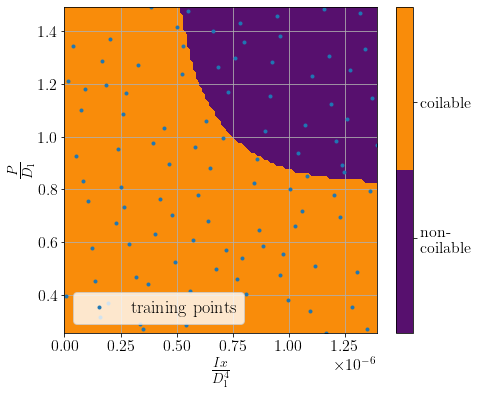

In [4]:

Z = np.concatenate([Z_coiled, Z_failed])
Ix = np.concatenate([Ix_coiled, Ix_failed])
PD = np.concatenate([PD_coiled, PD_failed])

X_class = np.vstack([Ix, PD]).T
scaler_class = StandardScaler().fit(X_class)
X_class_scaled=scaler_class.transform(X_class)
x, y = np.meshgrid(np.linspace(0, max(Ix), 100), np.linspace(min(PD), max(PD), 100))
Xnew_class = np.vstack((x.ravel(), y.ravel())).T
Xnew_scaled_class=scaler_class.transform(Xnew_class)  

m_class = GPy.models.GPClassification(X_class_scaled, Z[:, None])

idx_not_classified, idx_classified = plot_GP_classification_2d(X_class, Xnew_scaled_class, m_class, 
                                                               x, y, xlab  = r'$\frac{Ix}{D_1^4}$', 
                                                               ylab = r'$\frac{P}{D_1}$', title = None, 
                                                               savepath = 'Figures/13_GP_classification.pdf')
    
plt.grid(True)

## High fidelity GP regression

In [5]:
#training data
X1 = E_dict['{Ix}{D_1^4}']
X2 = E_dict['{P}{D_1}']
X = np.vstack([X1, X2]).T

Y = E_dict['P_crit']
Y1 = E_dict['E_abs']

#test points
x, y = np.meshgrid(np.linspace(0, max(X1), 100), np.linspace(min(X2), max(X2), 100))
Xnew = np.vstack((x.ravel(), y.ravel())).T

scaler = StandardScaler().fit(X)
X_scaled=scaler.transform(X)
Xnew_scaled=scaler.transform(Xnew) 

### Critical buckling load $P_{crit}$

In [6]:
kr = GPy.kern.Matern52(2, active_dims = [0, 1], name = 'matern')
np.random.seed(1)
m = GPy.models.GPRegression(X_scaled, Y[:, None], kr)
m.optimize_restarts(3)
m

Optimization restart 1/3, f = 16.753218017372035
Optimization restart 2/3, f = 16.753218023993654
Optimization restart 3/3, f = 16.753217999872057


GP_regression.,value,constraints,priors
matern.variance,9361.576452325313,+ve,
matern.lengthscale,7.348600421445691,+ve,
Gaussian_noise.variance,5.562684646268137e-309,+ve,


GP prediction with noise

Name : GP regression
Objective : 16.753217999872057
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  matern.variance          |       9361.576452325313  |      +ve      |        
  matern.lengthscale       |       7.348600421445691  |      +ve      |        
  Gaussian_noise.variance  |  5.562684646268137e-309  |      +ve      |        


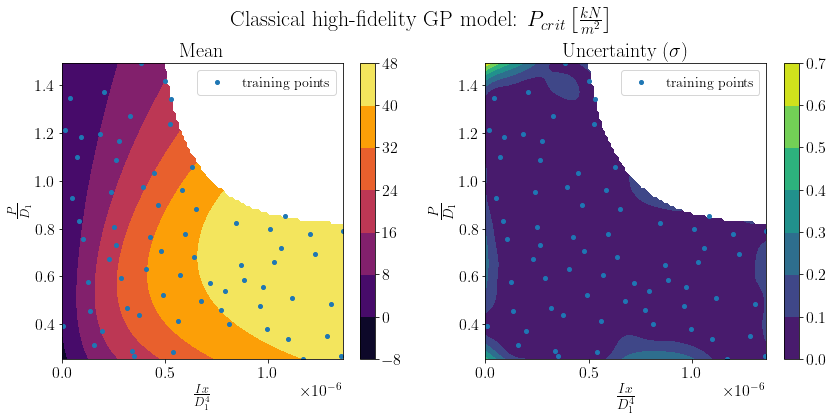

In [7]:
from QGP_metamaterial_postproc import plot_GP_2d

plot_GP_2d(X, Xnew_scaled, m, x, y, idx_class = idx_not_classified,
            xlab  = r'$\frac{Ix}{D_1^4}$', 
            ylab = r'$\frac{P}{D_1}$',  
           suptitle = 'Classical high-fidelity GP model: $P_{crit}\\left[\\frac{kN}{m^2}\\right]$', 
          split_plots = False)
                  


### Absorbed energy $E_{abs}$

In [8]:
kr_e = GPy.kern.Matern52(2, active_dims = [0, 1], name = 'matern')
Eabs = E_dict['E_abs']
np.random.seed(1)
m_e = GPy.models.GPRegression(X_scaled, Eabs[:, None], kr)
m_e.optimize_restarts(3)
m_e

Optimization restart 1/3, f = 134.8847370642674
Optimization restart 2/3, f = 127.73147610401622
Optimization restart 3/3, f = 140.14076381209287


GP_regression.,value,constraints,priors
matern.variance,210.17246664545473,+ve,
matern.lengthscale,1.907934665428319,+ve,
Gaussian_noise.variance,0.3311867422239311,+ve,


GP prediction with noise

Name : GP regression
Objective : 127.73147610401622
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  matern.variance          |  210.17246664545473  |      +ve      |        
  matern.lengthscale       |   1.907934665428319  |      +ve      |        
  Gaussian_noise.variance  |  0.3311867422239311  |      +ve      |        


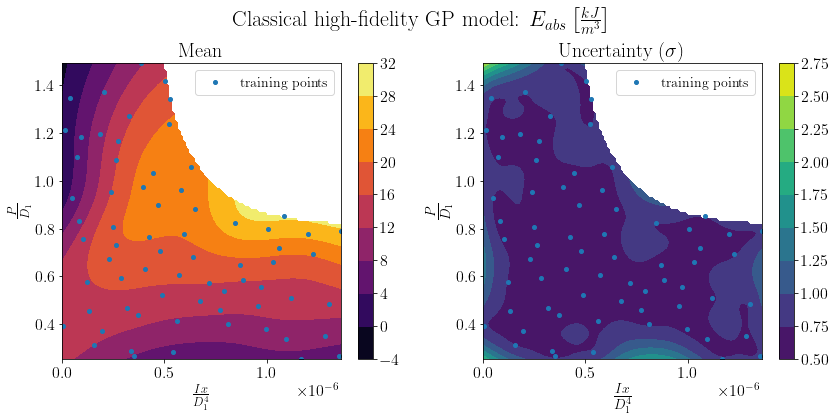

In [9]:
plot_GP_2d(X, Xnew_scaled, m_e, x, y, idx_class = idx_not_classified,
            xlab  = r'$\frac{Ix}{D_1^4}$', 
            ylab = r'$\frac{P}{D_1}$',  
            suptitle = 'Classical high-fidelity GP model: $E_{abs}\\left[\\frac{kJ}{m^3}\\right]$',
            split_plots = False)
          

# P critical

## Classical reduced GP model (8 training points)

GP prediction with noise

Name : GP regression
Objective : 28.81349026686881
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  Mat52.variance           |      753.9088843306378  |      +ve      |        
  Mat52.lengthscale        |     2.8347316593522405  |      +ve      |        
  Gaussian_noise.variance  |  9.931010744479322e-32  |      +ve      |        


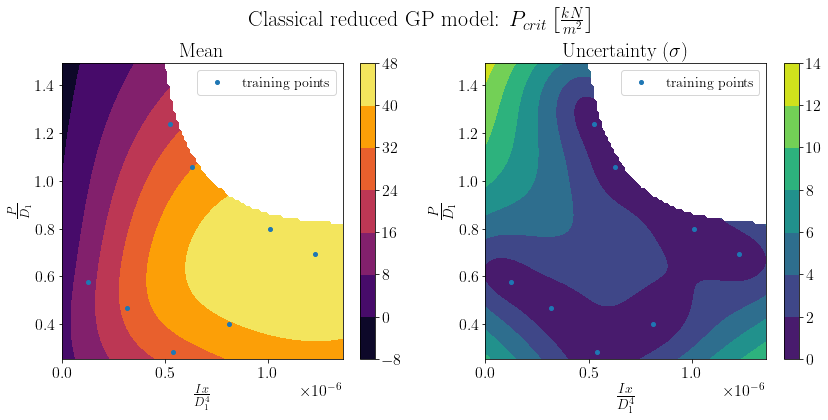

In [10]:
x, y = np.meshgrid(np.linspace(0, max(X1), 100), np.linspace(min(X2), max(X2), 100))


np.random.seed(2)
m8 = GPy.models.GPRegression(X_scaled[:8], Y[:8, None], GPy.kern.Matern52(2))
m8.optimize()

plot_GP_2d(X[:8], Xnew_scaled, m8, x, y, idx_class = idx_not_classified,
                xlab  = r'$\frac{Ix}{D_1^4}$', 
                ylab = r'$\frac{P}{D_1}$', 
                suptitle = 'Classical reduced GP model: $P_{crit}\\left[\\frac{kN}{m^2}\\right]$' ,  
                split_plots = False)


### System Eigenvalues 

Checking the eigenvalues of the reduced GP system, comparing against the QGP resolution threshold. 

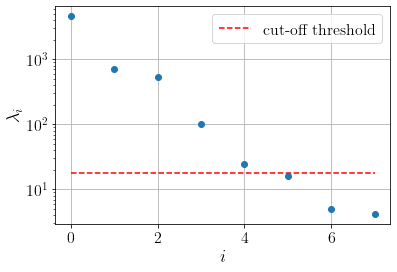

In [11]:
mat = m8.kern.K(X_scaled[:8], X_scaled[:8])
eigs = np.linalg.eigvals(mat)
plt.semilogy(eigs, 'o')


k = 8
threshold = np.max(eigs)/(2**k-1)
plt.semilogy(np.arange(len(eigs)),
             np.ones(len(eigs))*threshold, 
             '--r', label = 'cut-off threshold')
plt.ylabel('$\lambda_i$')
plt.xlabel('$i$')
plt.legend()
plt.grid(True)
plt.show()

### Preparing QGP inputs

In [12]:
x, y = np.meshgrid(np.linspace(0, max(X1), 7), np.linspace(min(X2), max(X2), 7))
Xnew_test = np.vstack((x.ravel(), y.ravel())).T
Xnew_test_scaled = scaler.transform(Xnew_test)

U_list = []
for i in range(49):
    U_list.append(m8.kern.K(Xnew_test_scaled, X_scaled[:8])[i, :])

    
input_dictionary = {}
experiment_name = 'PD-Ix-100_8x8-49'
#dir_name = 'serial_experiment_2d/'


input_dictionary['experiment_name'] = experiment_name
input_dictionary['n'] = 8
input_dictionary['k'] = 8
input_dictionary['tslc'] = 40
input_dictionary['u_list'] = U_list

V = Y[:8]
input_dictionary['v_list'] = V
input_dictionary['matrix'] = mat
input_dictionary['Xnew'] = Xnew

#UNCOMMENT TO OVERWRITE
#f =open(experiment_name + '.pickle','wb')
#pickle.dump(input_dictionary, f)
#f.close()

## QGP results

### QGP vs classical reduced GP model

The same GP system (based on the same 8 training points, with the same parameters) was solved calssically and with the quantum algorithm. Here he results are compared to evaluate the differences.

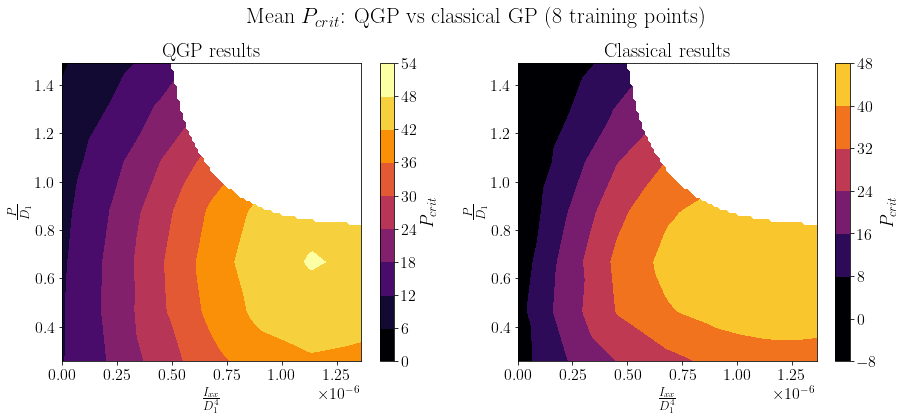

In [13]:
experiment_name = 'PD-Ix-100_8x8-49'
test_8x8_1 = postproc_QGP_2d(experiment_name, Xnew_test)
test_8x8_1.plot_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = 'Mean $P_{crit}$:  QGP vs classical GP (8 training points)',
                         idx_class= (idx_not_classified[1],idx_not_classified[0]))

NEGATIVE VARIANCE ENOUNTERED, replaced with 0


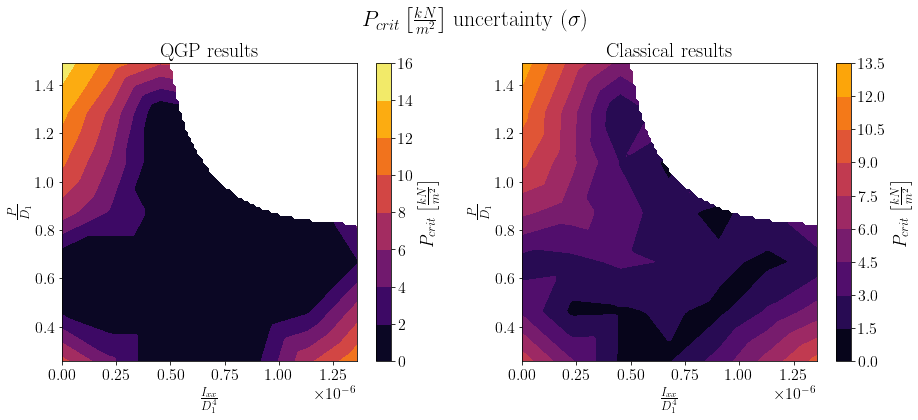

In [14]:
experiment_name = 'PD-Ix-100_8x8-49'
test_8x8_1_var = postproc_QGP_2d(experiment_name, Xnew_test, var_data = True, m = m8, 
                                 Xnew_test_scaled = Xnew_test_scaled)


test_8x8_1_var.plot_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                        suptitle = '$P_{crit}\\left[\\frac{kN}{m^2}\\right]$ uncertainty ($\sigma$)',
                        zlabel = '$P_{crit}\\left[\\frac{kN}{m^2}\\right]$', 
                        idx_class= (idx_not_classified[1],idx_not_classified[0]), vmin = -1e-2, vmax = 16)



### QGP error wrt classical GP

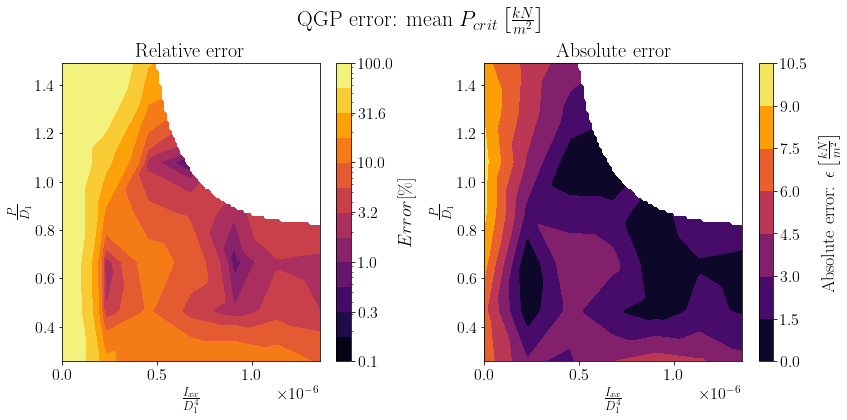

In [15]:
test_8x8_1.plot_error_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = 'QGP error: mean $P_{crit} \\left[\\frac{kN}{m^2}\\right]$',vmax = 99,
                        idx_class= (idx_not_classified[1],idx_not_classified[0]), 
                        zlabel2 = 'Absolute error: $\epsilon \\left[\\frac{kN}{m^2}\\right]$') 


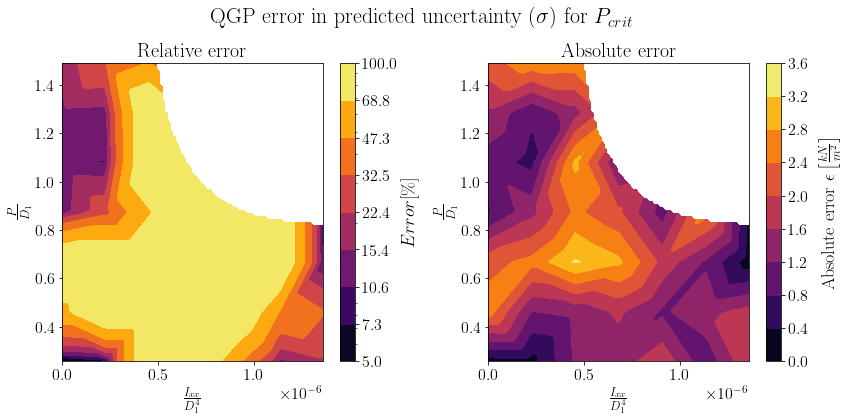

In [16]:
test_8x8_1_var.plot_error_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                                suptitle = 'QGP error in predicted uncertainty ($\sigma$) for $P_{crit}$',
                                vmax = 10,levels = np.logspace(0.7, 2, 9), 
                                zlabel2 = 'Absolute error $\epsilon \\left[\\frac{kN}{m^2}\\right]$',
                                idx_class= (idx_not_classified[1],idx_not_classified[0]), 
                                variance_case = True)

### QGP vs PCA approximation of GP

In order to demonstrate that the low-rank approixmation induced in QGP is similar to classical PCA, the classical reduced GP system was approximated with PCA using first 6 eigenmodes (above the resolution threshold, see plot in sec 3.1.1 in this notebook). The relative error of such an approximated system (against the full GP with 8 modes) was then compared against the error of QGP. 

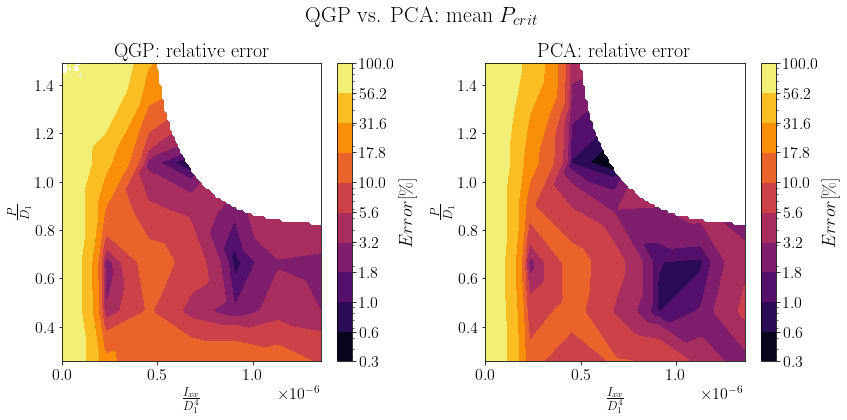

(<Figure size 864x432 with 4 Axes>, <Figure size 864x432 with 2 Axes>)

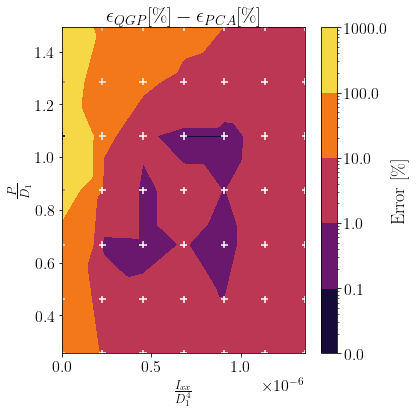

In [17]:
test_8x8_1.plot_verification_countour(input_dictionary, xbounds = [0, max(X1), min(X2), max(X2)],
                                        CMAP = 'inferno', xlabel = '$\\frac{I_{xx}}{D_1^4}$',
                                        suptitle = 'QGP vs. PCA: mean $P_{crit}$ ', 
                                        ylabel = '$\\frac{P}{D_1}$', zlabel = '$Error[\%]$',
                                        idx_class=  (idx_not_classified[1],idx_not_classified[0])) 
                               

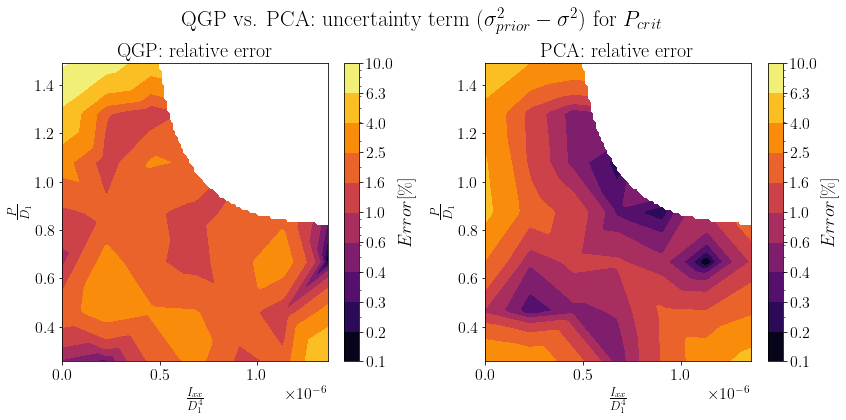

(<Figure size 864x432 with 4 Axes>, <Figure size 864x432 with 2 Axes>)

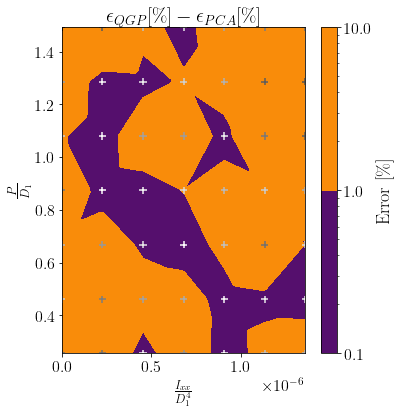

In [18]:
test_8x8_1_var.plot_verification_countour(input_dictionary, xbounds = [0, max(X1), min(X2), max(X2)],
                                            CMAP = 'inferno', xlabel = '$\\frac{I_{xx}}{D_1^4}$', 
                                            suptitle = 'QGP vs. PCA: uncertainty term ($\sigma^2_{prior} - \sigma^2)$ for $P_{crit}$', 
                                            ylabel = '$\\frac{P}{D_1}$', zlabel = '$Error[\%]$',variance_case = True ,
                                            levels = np.logspace(-1, 1, 11), 
                                            idx_class=  (idx_not_classified[1],idx_not_classified[0]))
                                         


### Combined plots: Mean + Uncertainty

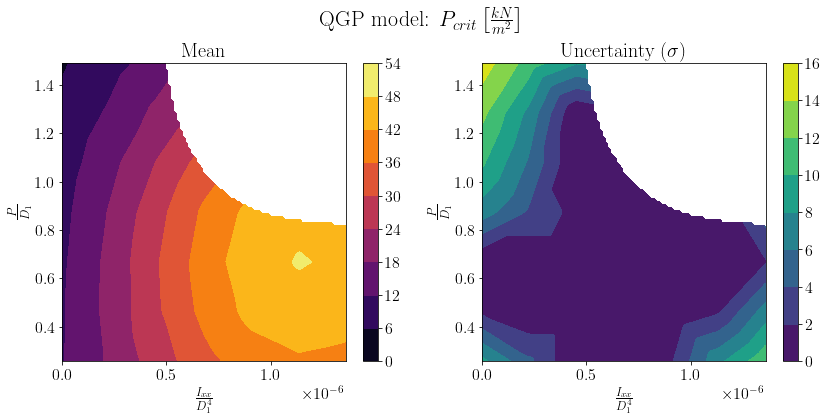

In [19]:
qgp_mean = test_8x8_1._QGP_predict
points_mean = test_8x8_1._xqgp

qgp_std = test_8x8_1_var._QGP_predict
points_std = test_8x8_1_var._xqgp 

combined_qgp_plot(qgp_mean, points_mean, qgp_std, points_std, X1, X2, idx_not_classified,
                 split_plots = False, 
                 title = '$P_{crit} \\left[\\frac{kN}{m^2}\\right]$')


# Eabs 



## Classical reduced GP model

Classical GP model trained on the QGP training set (8 points) used later for reference.

GP prediction with noise

Name : GP regression
Objective : 26.5657251199924
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  Mat52.variance           |      196.9809289011732  |      +ve      |        
  Mat52.lengthscale        |     1.9721484486626826  |      +ve      |        
  Gaussian_noise.variance  |  1.752579728881602e-05  |      +ve      |        


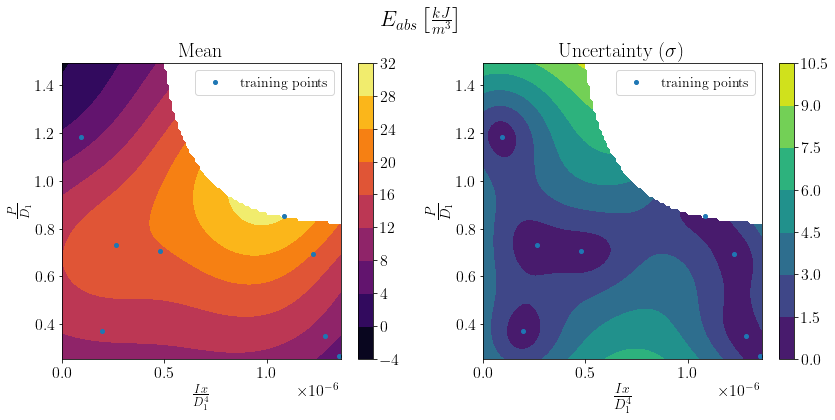

In [20]:
x, y = np.meshgrid(np.linspace(0, max(X1), 100), np.linspace(min(X2), max(X2), 100))

np.random.seed(2)
test_set =  np.random.choice(len(X_scaled), 8)

np.random.seed(2)
m8_e = GPy.models.GPRegression(X_scaled[test_set], Eabs[test_set, None], GPy.kern.Matern52(2)) # can be also on residual
m8_e.optimize()

plot_GP_2d(X[test_set], Xnew_scaled, m8_e, x, y, idx_class = idx_not_classified,
            xlab  = r'$\frac{Ix}{D_1^4}$', 
            ylab = r'$\frac{P}{D_1}$', 
               suptitle = '$E_{abs}\\left[\\frac{kJ}{m^3}\\right]$', 
        split_plots = False           )
          

### QGP input

Preparation of input data for QGP. 

In [21]:
approximate_num_of_samples = 100
hj = int(np.round(np.sqrt(100/0.8)))

x, y = np.meshgrid(np.linspace(0, max(X1), hj), np.linspace(min(X2), max(X2), hj))
Xnew_test = np.vstack((x.ravel(), y.ravel())).T
Z_new_test = m_class.predict(scaler_class.transform(Xnew_test))
Xnew_test_classified = Xnew_test[np.where(Z_new_test[0]>0.5)[0], :]
Xnew_test_additional = Xnew_test[list(set(np.where(Z_new_test[0]<0.5)[0]) - set(np.where(Z_new_test[0]<0.2)[0]))]

Xnew_test_classified  = np.vstack((Xnew_test_classified , Xnew_test_additional ))

Xnew_test_scaled = scaler.transform(Xnew_test_classified)



U_list = []
for i in range(len(Xnew_test_scaled )):
    U_list.append(m8_e.kern.K(Xnew_test_scaled, X_scaled[test_set])[i, :])
    
input_dictionary = {}
experiment_name = 'PD-Ix-100-100-Eabs'

input_dictionary['experiment_name'] = experiment_name
input_dictionary['n'] = 8
input_dictionary['k'] = 8
input_dictionary['tslc'] = 40
input_dictionary['u_list'] = U_list

V = Eabs[test_set]
input_dictionary['v_list'] = V
input_dictionary['matrix'] = m8_e.kern.K(X_scaled[test_set], X_scaled[test_set])
input_dictionary['Xnew'] = Xnew_test_classified

#UNCOMMENT TO OVERWRITE
#f =open(experiment_name + '.pickle','wb')
#pickle.dump(input_dictionary, f)
#f.close()

### Input validation 

GP prediction with noise

Name : GP regression
Objective : 26.5657251199924
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  Mat52.variance           |      196.9809289011732  |      +ve      |        
  Mat52.lengthscale        |     1.9721484486626826  |      +ve      |        
  Gaussian_noise.variance  |  1.752579728881602e-05  |      +ve      |        


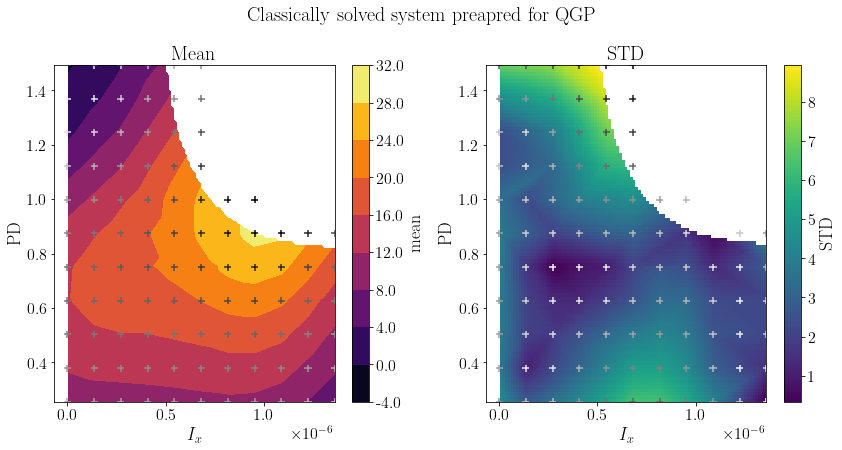

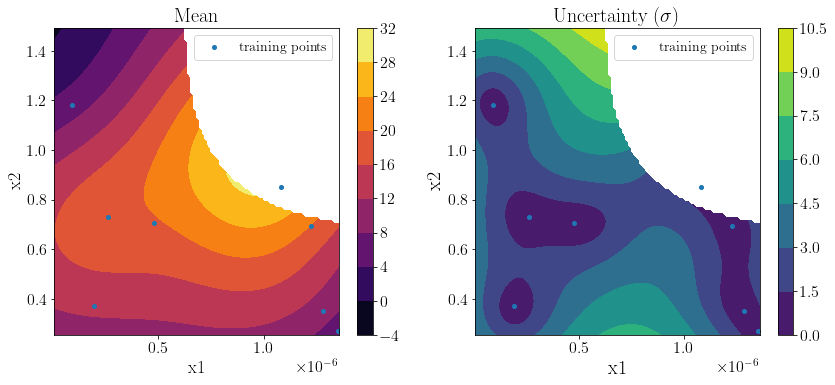

In [22]:
from QGP_metamaterial_postproc import dict_validation_plot

x_full, y_full = np.meshgrid(np.linspace(min(X1), max(X1), 100), np.linspace(min(X2), max(X2), 100))

dict_validation_plot(input_dictionary, [min(X1), max(X1), min(X2), max(X2)],
                     m8_e,  X[test_set], Xnew_scaled, x_full, y_full, 
                     idx_class = (idx_not_classified[1],idx_not_classified[0]) )



## QGP results


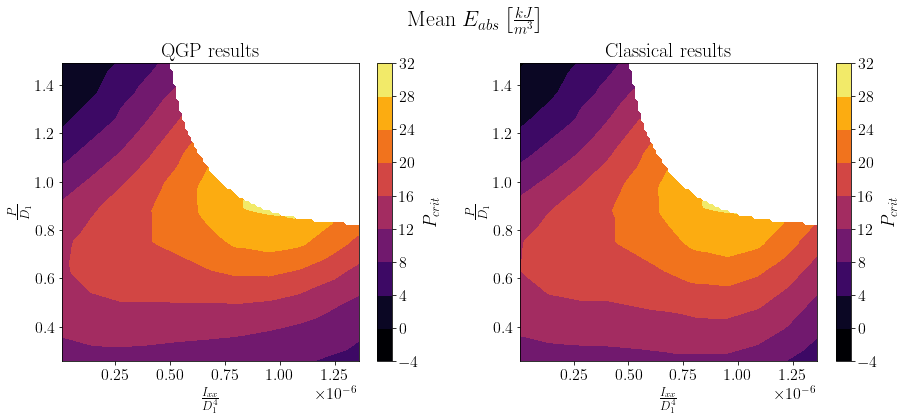

In [23]:
from QGP_metamaterial_postproc import postproc_QGP_2d

experiment_name = 'PD-Ix-100-100-Eabs'
test_E_mean = postproc_QGP_2d(experiment_name, Xnew_test_classified)
test_E_mean.plot_countour(xbounds = [min(X1), max(X1), min(X2), max(X2)],
                         suptitle = 'Mean $E_{abs}\\left[\\frac{kJ}{m^3}\\right]$',
                        idx_class= (idx_not_classified[1],idx_not_classified[0])
                          , vmin = 0, vmax = 32, plot_query_points = False)
                         


NEGATIVE VARIANCE ENOUNTERED, replaced with 0


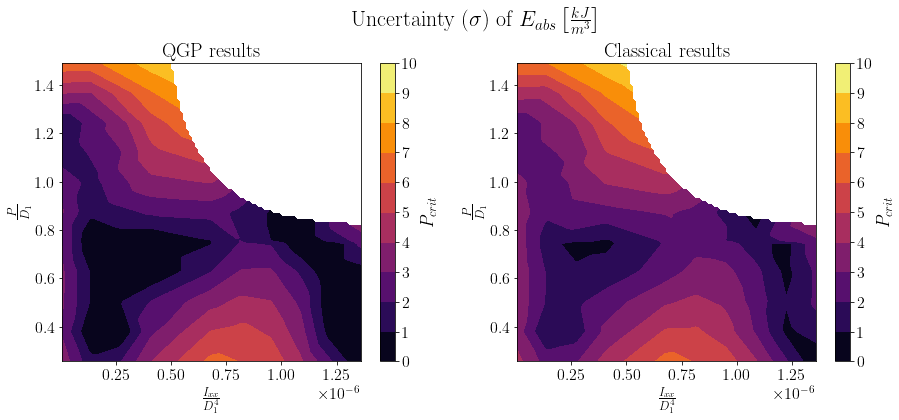

In [24]:
experiment_name = 'PD-Ix-100-100-Eabs'
test_E_var = postproc_QGP_2d(experiment_name, Xnew_test_classified, var_data = True, m = m8_e, 
                                 Xnew_test_scaled = Xnew_test_scaled)

test_E_var.plot_countour(xbounds = [min(X1), max(X1), min(X2), max(X2)],
                         suptitle = 'Uncertainty ($\sigma$) of $E_{abs} \\left[\\frac{kJ}{m^3}\\right]$',
                         idx_class=  (idx_not_classified[1],idx_not_classified[0]), 
                         vmin = -1e-2, vmax = 10, levels = np.linspace(0, 10, 11))


### QGP error wrt classical GP

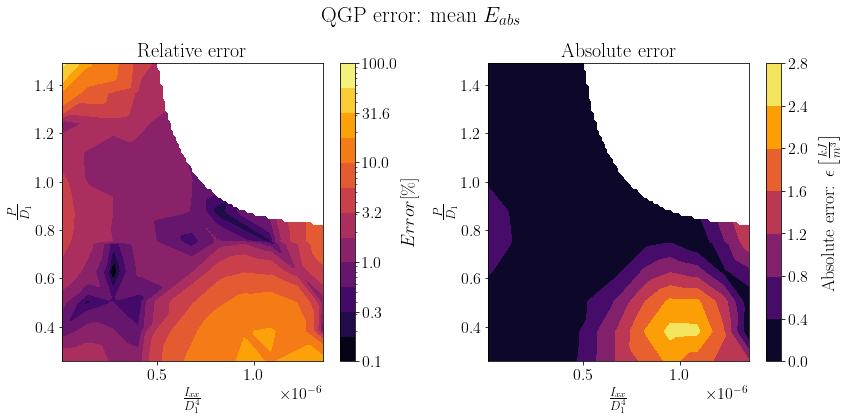

In [25]:
test_E_mean.plot_error_countour(xbounds = [min(X1), max(X1), min(X2), max(X2)],
                        suptitle = 'QGP error: mean $E_{abs}$',
                        idx_class= (idx_not_classified[1],idx_not_classified[0]), 
                        zlabel2 = 'Absolute error: $\epsilon \\left[\\frac{kJ}{m^3}\\right]$')


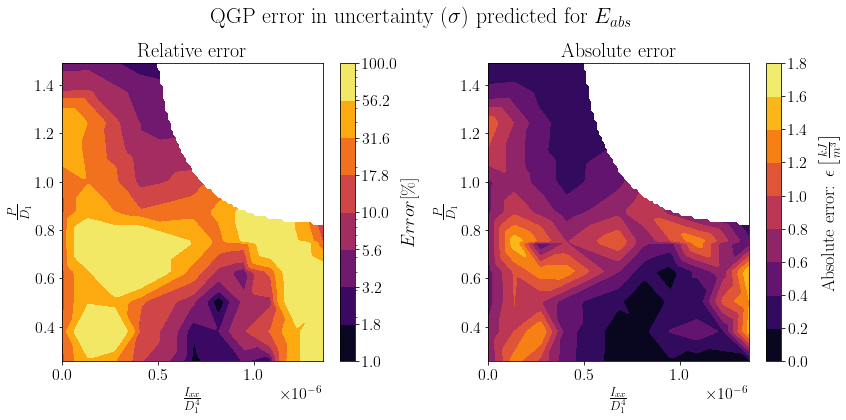

In [26]:
test_E_var.plot_error_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                                suptitle = 'QGP error in uncertainty ($\sigma$) predicted for $E_{abs}$',
                                idx_class= (idx_not_classified[1],idx_not_classified[0]), 
                                vmax = 100., 
                                variance_case = True, 
                                levels = np.logspace(0,2, 9 ), 
                                zlabel2 = 'Absolute error: $\epsilon\\left[\\frac{kJ}{m^3}\\right]$')


### QGP vs PCA approximation of GP

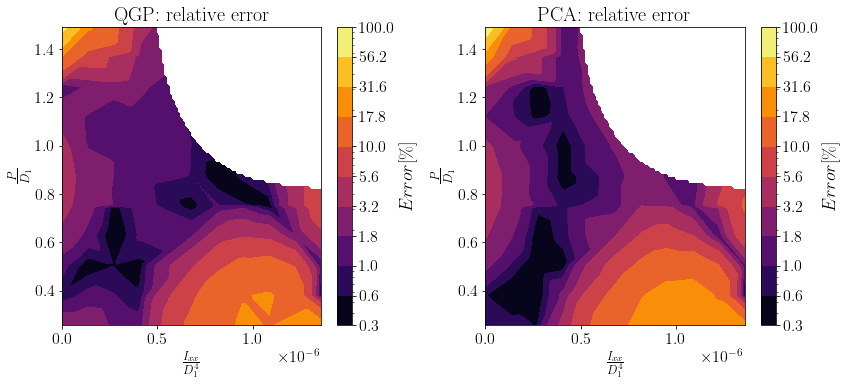

(<Figure size 864x432 with 4 Axes>, <Figure size 864x432 with 2 Axes>)

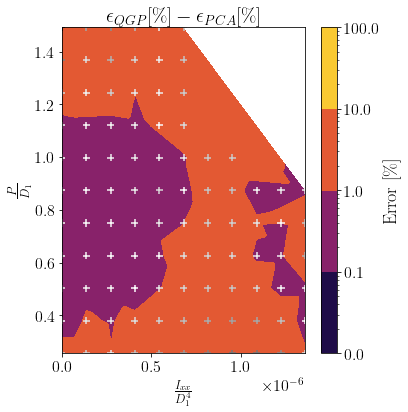

In [27]:
test_E_mean.plot_verification_countour(input_dictionary, xbounds = [0, max(X1), min(X2), max(X2)],
                                        CMAP = 'inferno', xlabel = '$\\frac{I_{xx}}{D_1^4}$', 
                                        suptitle = None, 
                                        ylabel = '$\\frac{P}{D_1}$', zlabel = '$Error[\%]$', 
                                        idx_class = (idx_not_classified[1],idx_not_classified[0]), 
                                        bar_format = '%.1f')


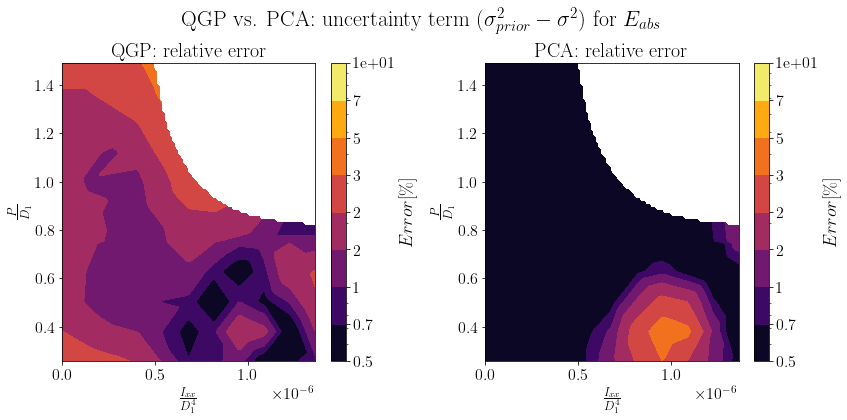

(<Figure size 864x432 with 4 Axes>, <Figure size 864x432 with 2 Axes>)

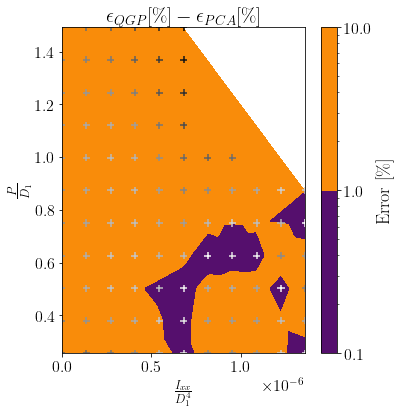

In [28]:
test_E_var.plot_verification_countour(input_dictionary, xbounds = [0, max(X1), min(X2), max(X2)],
                                        CMAP = 'inferno', xlabel = '$\\frac{I_{xx}}{D_1^4}$', 
                                        suptitle = 'QGP vs. PCA: uncertainty term ($\sigma^2_{prior} -\sigma^2$) for $E_{abs}$', 
                                        ylabel = '$\\frac{P}{D_1}$', zlabel = '$Error[\%]$', 
                                        idx_class = (idx_not_classified[1],idx_not_classified[0]),
                                        levels = np.logspace(-0.3, 1, 9),
                                        bar_format = '%1.1g', variance_case = True)


## QGP combined plot: mean + uncertainty

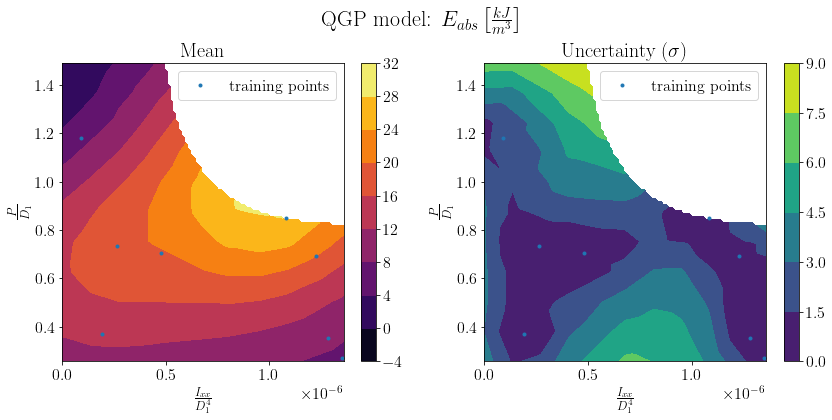

In [29]:
qgp_mean = test_E_mean._QGP_predict
points_mean = test_E_mean._xqgp

qgp_std = test_E_var._QGP_predict
points_std = test_E_var._xqgp 

combined_qgp_plot(qgp_mean, points_mean, qgp_std, points_std,X1, X2, idx_not_classified,
                  title = '$E_{abs}\\left[\\frac{kJ}{m^3}\\right]$', 
                 Xtr = X[test_set], 
                 split_plots = False                  )

# Objective function


In [30]:
xbounds = [0, max(X1), min(X2), max(X2)]
grid_x, grid_y = np.mgrid[xbounds[0]:xbounds[1]:100j,
                          xbounds[2]:xbounds[3]:100j]

x, y = np.meshgrid(np.linspace(0, max(Ix), 100), np.linspace(min(PD), max(PD), 100))
Xnew = np.vstack((x.ravel(), y.ravel())).T
Xnew_scaled=scaler.transform(Xnew) 


mean_Pcrit_GPfull, Cov = m.predict(Xnew_scaled, full_cov=False)
mean_E_GPfull, cov= m_e.predict(Xnew_scaled, full_cov=False)

In [31]:
qgp_mean_E = test_E_mean._QGP_predict
points_mean_E = test_E_mean._xqgp

qgp_mean_P = test_8x8_1._QGP_predict
points_mean_P = test_8x8_1._xqgp

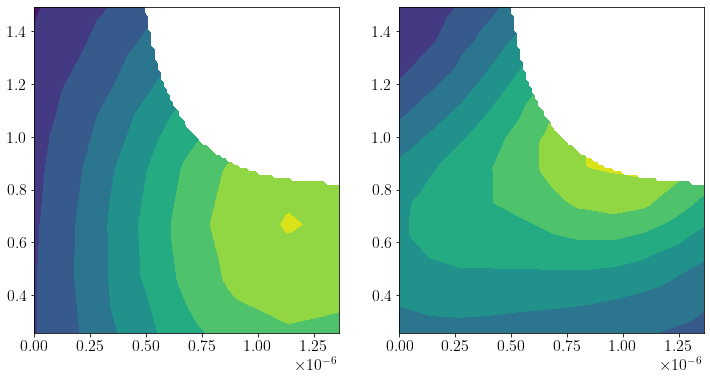

In [32]:
xbounds = [0, max(X1), min(X2), max(X2)]
xd, yd = np.mgrid[xbounds[0]:xbounds[1]:100j, xbounds[2]:xbounds[3]:100j]
grid_zE = griddata(points_mean_E ,qgp_mean_E , (xd, yd) , method='linear')
grid_zE[(idx_not_classified[1],idx_not_classified[0])] = np.nan

grid_zP = griddata(points_mean_P ,qgp_mean_P , (xd, yd) , method='linear')
grid_zP[(idx_not_classified[1],idx_not_classified[0])] = np.nan

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.contourf(xd, yd, grid_zP)

plt.subplot(1, 2, 2)
plt.contourf(xd, yd, grid_zE)

Text(0.5, 0.98, 'Objective function')

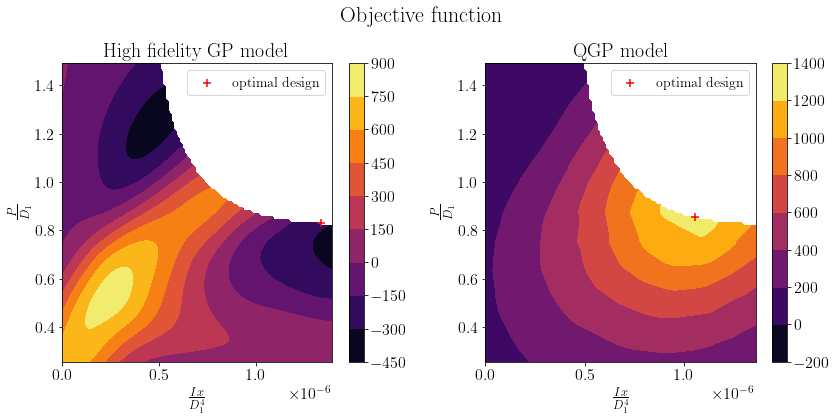

In [33]:
fig = plt.figure(figsize = (12, 6))


plt.subplot(1, 2,1)

objective_hifi = mean_Pcrit_GPfull*mean_E_GPfull

objective_hifi =objective_hifi.reshape(x.shape)
objective_hifi[idx_not_classified] = np.nan

plt.contourf(x, y, objective_hifi, cmap = 'inferno')
plt.colorbar()
ind = np.unravel_index(np.argmax(objective_hifi, axis=None), objective_hifi.shape)
plt.scatter(x[ind],y[ind], marker = '+', s = 60,c = 'r', label = 'optimal design')
plt.legend(fontsize = 14)
plt.ticklabel_format(style='sci', axis='x',  scilimits=(-1,0))
plt.xlabel(r'$\frac{Ix}{D_1^4}$') 
plt.ylabel(r'$\frac{P}{D_1}$')
plt.title('High fidelity GP model', size = 20)




plt.subplot(1, 2,2)


objective_QGP = grid_zP * grid_zE 
plt.contourf(xd, yd, objective_QGP, cmap = 'inferno')
plt.colorbar()
plt.xlabel(r'$\frac{Ix}{D_1^4}$') 
plt.ylabel(r'$\frac{P}{D_1}$')
plt.title('QGP model', size = 20)
plt.ticklabel_format(style='sci', axis='x', scilimits=(-1,0))

indq = np.unravel_index(np.argmax(np.nan_to_num(objective_QGP) , axis=None), objective_QGP.shape)
plt.scatter(xd[indq],yd[indq], marker = '+', s = 60,c = 'r', label = 'optimal design')
plt.legend(fontsize = 14)
plt.tight_layout()

plt.subplots_adjust(top=0.85)     # Add space at top
plt.suptitle('Objective function', y= 0.98, size = 22)


In [34]:
print('High fidelity GP:')
print('Optimal design point: ', x[ind],y[ind])
print('Pcrit: ', mean_Pcrit_GPfull.reshape(x.shape)[ind])
print('Eabs: ', mean_E_GPfull.reshape(x.shape)[ind])


print('\nQGP:')
print('Optimal design point: ', xd[indq],yd[indq])
print('Pcrit: ', grid_zP[indq])
print('Eabs: ',grid_zE[indq])




High fidelity GP:
Optimal design point:  1.3368833353871615e-06 0.8300654902863842
Pcrit:  -9.261590008627095
Eabs:  29.155481283107253

QGP:
Optimal design point:  1.0577110620591065e-06 0.8550494143603564
Pcrit:  (45.889523702594566+0j)
Eabs:  (28.15915314586212+0j)


# Uncertainty of the 8-point model

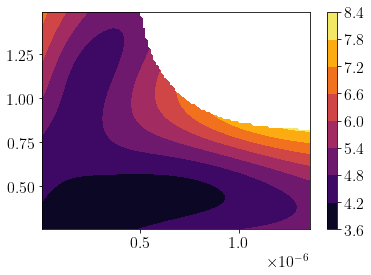

In [35]:
x, y = np.meshgrid(np.linspace(min(X1), max(X1), 100), np.linspace(min(X2), max(X2), 100))

n_sample_systems = 100
Means_array = []

for i in range(n_sample_systems):
    np.random.seed(i)
    test_set =  np.random.choice(len(X_scaled), 8)
    np.random.seed(i)
    m8_e_test = GPy.models.GPRegression(X_scaled[test_set], Eabs[test_set, None], GPy.kern.Matern52(2)) # can be also on residual
    m8_e_test.optimize()
    
    
    mean, Cov = m8_e_test.predict(Xnew_scaled, full_cov=False) 
    mean_mat = mean.reshape(x.shape)
    mean_mat[idx_not_classified] = np.nan
    Means_array.append(mean_mat)
    
stats = np.array(Means_array)
stds_E = np.std(stats, axis = 0)


plt.subplot(1,1,1)
plt.contourf(x, y,stds_E  , cmap = 'inferno', label = "STD in estimation between prediction of 5 moels with random")
plt.colorbar()


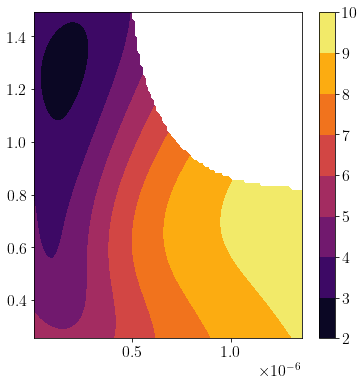

In [36]:
x, y = np.meshgrid(np.linspace(min(X1), max(X1), 100), np.linspace(min(X2), max(X2), 100))

n_sample_systems = 100
Means_array = []

X_scaled[:8], Y[:8, None]

for i in range(n_sample_systems):
    np.random.seed(i)
    test_set =  np.random.choice(len(X_scaled), 8)
    np.random.seed(i)
    m8_test = GPy.models.GPRegression(X_scaled[test_set], Y[test_set, None], GPy.kern.Matern52(2)) # can be also on residual
    m8_test.optimize()
    
    
    mean, Cov = m8_test.predict(Xnew_scaled, full_cov=False) 
    mean_mat = mean.reshape(x.shape)
    mean_mat[idx_not_classified] = np.nan
    Means_array.append(mean_mat)
    
    
stats = np.array(Means_array)
stds_Pcrit = np.std(stats, axis = 0)


fig = plt.figure(figsize=(6, 6))
plt.subplot(1,1,1)
plt.contourf(x, y,stds_Pcrit , cmap = 'inferno', label = "STD in estimation between prediction of 5 moels with random")
plt.colorbar()


In [37]:
mean_true, Cov = m.predict(Xnew_scaled, full_cov=False) 
mean_true_E, Cov = m_e.predict(Xnew_scaled, full_cov=False) 

Text(0.5, 0.98, 'Standard deviation of mean values predicted with 100 random reduced GP models')

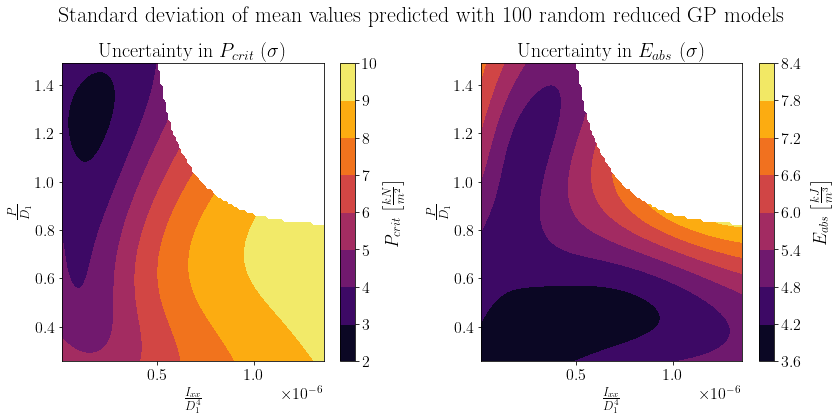

In [38]:
stats = np.array(Means_array)
stds = np.std(stats, axis = 0)

fig = plt.figure(figsize = (12, 6))

xlab = '$\\frac{I_{xx}}{D^4_1}$'
ylab = '$\\frac{P}{D_1}$'

plt.subplot(1,2,1)
plt.contourf(x, y,stds_Pcrit  , cmap = 'inferno', label = "STD in estimation between prediction of 100 moels with random")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel(ylab, size = 18)
plt.xlabel(xlab, size =18)
plt.title("Uncertainty in $P_{crit}$ ($\sigma$)", size = 20)
plt.colorbar(label = '$P_{crit}\\left[\\frac{kN}{m^2}\\right]$')


plt.subplot(1,2,2)
plt.contourf(x, y,stds_E  , cmap = 'inferno', label = "STD in estimation between prediction of 100 moels with random")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel(ylab, size = 18)
plt.xlabel(xlab, size =18)
plt.title("Uncertainty in $E_{abs}$ ($\sigma$)", size = 20)

clb = plt.colorbar()
clb.set_label('$E_{abs}\\left[\\frac{kJ}{m^3}\\right]$', labelpad=9)

plt.tight_layout()
plt.subplots_adjust( top=0.85)
fig.suptitle('Standard deviation of mean values predicted with 100 random reduced GP models', y = 0.98, size = 22)


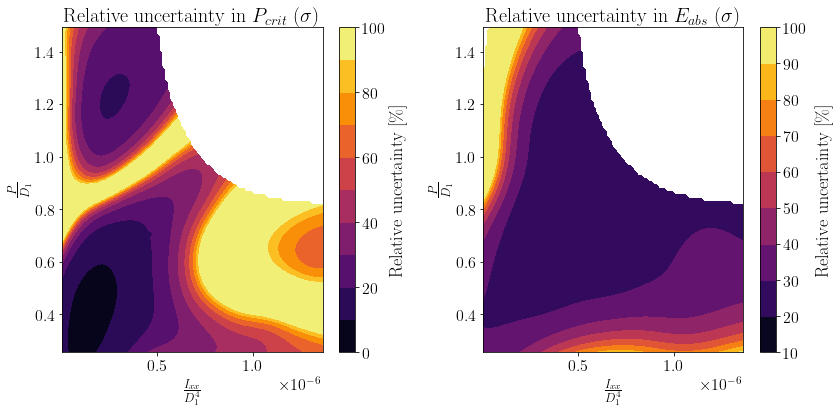

In [39]:
stats = np.array(Means_array)
stds_rel = np.std(stats, axis = 0)

fig = plt.figure(figsize = (12, 6))

xlab = '$\\frac{I_{xx}}{D^4_1}$'
ylab = '$\\frac{P}{D_1}$'

std_rel_p = np.abs(100.*stds_Pcrit/mean_true.reshape(x.shape))
std_rel_p[np.where(std_rel_p>100.)] = 100.

std_rel_E = 100.*stds_E/mean_true_E.reshape(x.shape)
std_rel_E[np.where(std_rel_E>100.)] = 100.
std_rel_E[np.where(std_rel_E<0.)] = np.nan

plt.subplot(1,2,1)
plt.contourf(x, y, std_rel_p , cmap = 'inferno', 
             label = "STD in estimation between prediction of 100 models with random",
            levels = np.linspace(0, 100, 11)
            )

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel(ylab, size = 18)
plt.xlabel(xlab, size =18)
plt.title("Relative uncertainty in $P_{crit}$ ($\sigma$)", size = 20)
plt.colorbar(label = 'Relative uncertainty $[\%]$')


plt.subplot(1,2,2)
plt.contourf(x, y, std_rel_E  , cmap = 'inferno', 
             label = "STD in estimation between prediction of 100 moels with random", levels = np.linspace(10, 100, 10))


plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel(ylab, size = 18)
plt.xlabel(xlab, size =18)
plt.title("Relative uncertainty in $E_{abs}$ ($\sigma$)", size = 20)

clb = plt.colorbar()
clb.set_label(label = 'Relative uncertainty $[\%]$', labelpad=9)

plt.tight_layout()


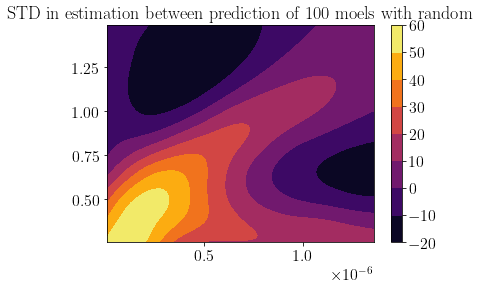

In [40]:
plt.contourf(x, y, mean_true.reshape(x.shape)  , cmap = 'inferno')
plt.title("STD in estimation between prediction of 100 moels with random")
plt.colorbar()

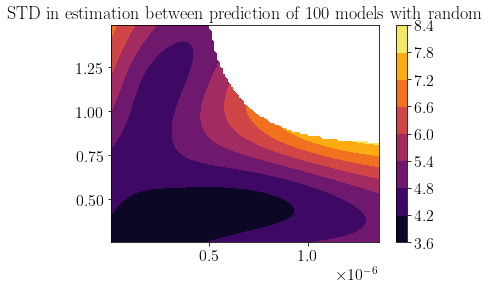

In [41]:
plt.contourf(x, y, stds_E  , cmap = 'inferno')
plt.title("STD in estimation between prediction of 100 models with random")
plt.colorbar()